# train data vectorizing & labeling

In [1]:
# train data path
import os
import numpy as np
from numpy import array
TRAIN_DIR = 'D:/MNIST/trainingSet/'
train_folder_list = array(os.listdir(TRAIN_DIR))
train_folder_list

array(['0_zero', '1_one', '2_two', '3_three', '4_four', '5_five', '6_six',
       '7_seven', '8_eight', '9_nine'], dtype='<U7')

In [2]:
# path 라벨링
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()  # LabelEncoder Class 호출
integer_encoded = label_encoder.fit_transform(train_folder_list)
integer_encoded

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [3]:
# 라벨링 벡터화
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(categories='auto', sparse=False) 
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print('integer_encoded:\n', integer_encoded)
print('onehot_encoded:\n', onehot_encoded)

integer_encoded:
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
onehot_encoded:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [4]:
type(onehot_encoded)

numpy.ndarray

In [5]:
# 이미지를 불러와서 흑백으로 벡터화 및 라벨링
import cv2
train_input = []
train_label = []
for index in range(len(train_folder_list)):
    path = os.path.join(TRAIN_DIR, train_folder_list[index])
    path = path + '/'
    img_list = os.listdir(path)
    for img in img_list:
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # cv2.imread: paht경로에 있는 이미지를 흑백으로 불러옴
        train_input.append([np.array(img)])
        train_label.append([np.array(onehot_encoded[index])])

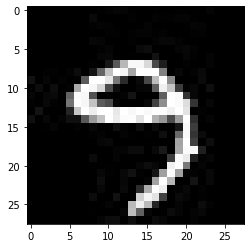

In [6]:
# 마지막 이미지 시각화
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [7]:
len(train_input) #train_input은 [[img],[img],...,[img]] 이런 형태

42000

### list형태를 np.array형태(42000,784)로 reshape

In [8]:
train_input = np.reshape(train_input, (-1, 784))
# 이때 -1은 정확한 개수를 모를때 사용. -1대신 42000 넣어도 상관x
train_label = np.reshape(train_label, (-1, 10))
train_input = np.array(train_input).astype(np.float32)
train_label = np.array(train_label).astype(np.float32)

#데이터 섞기
tmp = [[x,y] for x, y in zip(train_input, train_label)]
np.random.shuffle(tmp)
train_input = np.array([n[0] for n in tmp])
train_label = np.array([n[1] for n in tmp])

np.save("train_data.npy", train_input)
np.save("train_label.npy", train_label)
print('train_input.shape: ', train_input.shape)
print('train_label.shape: ', train_label.shape)

train_input.shape:  (42000, 784)
train_label.shape:  (42000, 10)


# test data vectorizing & labeling

In [9]:
TEST_DIR = 'D:/MNIST/testSet/'
test_folder_list = array(os.listdir(TEST_DIR))
 
test_input = []
test_label = []
 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(test_folder_list)
 
onehot_encoder = OneHotEncoder(categories='auto', sparse=False) 
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
 
for index in range(len(test_folder_list)):
    path = os.path.join(TEST_DIR, test_folder_list[index])
    path = path + '/'
    img_list = os.listdir(path)
    for img in img_list:
        img_path = os.path.join(path, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_input.append([np.array(img)])
        test_label.append([np.array(onehot_encoded[index])])
 
test_input = np.reshape(test_input, (-1, 784))
test_label = np.reshape(test_label, (-1, 10))
test_input = np.array(test_input).astype(np.float32)
test_label = np.array(test_label).astype(np.float32)

#데이터 섞기
tmp = [[x,y] for x, y in zip(test_input, test_label)]
np.random.shuffle(tmp)
test_input = np.array([n[0] for n in tmp])
test_label = np.array([n[1] for n in tmp])

np.save("test_input.npy",test_input)
np.save("test_label.npy",test_label)

# Autoencoder와 Softmax 분류기를 이용한 MNIST 분류기 구현

In [10]:
import tensorflow as tf

# 학습에 필요한 설정값들을 정의  
learning_rate_RMSProp = 0.02
learning_rate_GradientDescent = 0.01
num_epochs = 100         # 반복횟수
batch_size = 256          
display_step = 5         # 몇 Step마다 loss를 출력할지 결정
input_size = 784
hidden1_size = 128       # 첫번째 히든레이어의 노드 개수 
hidden2_size = 64        # 두번째 히든레이어의 노드 개수 

# 입력값과 출력값을 받기 위한 플레이스홀더를 정의
x = tf.placeholder(tf.float32, shape=[None, input_size])   
y = tf.placeholder(tf.float32, shape=[None, 10])         

In [11]:
# Autoencoder 구조를 정의
def build_autoencoder(x):
    # 인코딩(Encoding) - 784 -> 128 -> 64
    Wh_1 = tf.Variable(tf.random_normal([input_size, hidden1_size]))   
    bh_1 = tf.Variable(tf.random_normal([hidden1_size]))
    H1_output = tf.nn.sigmoid(tf.matmul(x, Wh_1) +bh_1)
    Wh_2 = tf.Variable(tf.random_normal([hidden1_size, hidden2_size]))
    bh_2 = tf.Variable(tf.random_normal([hidden2_size]))
    H2_output = tf.nn.sigmoid(tf.matmul(H1_output, Wh_2) +bh_2)
    # 디코딩(Decoding) 64 -> 128 -> 784
    Wh_3 = tf.Variable(tf.random_normal([hidden2_size, hidden1_size]))
    bh_3 = tf.Variable(tf.random_normal([hidden1_size]))
    H3_output = tf.nn.sigmoid(tf.matmul(H2_output, Wh_3) +bh_3)
    Wo = tf.Variable(tf.random_normal([hidden1_size, input_size]))
    bo = tf.Variable(tf.random_normal([input_size]))
    X_reconstructed = tf.nn.sigmoid(tf.matmul(H3_output,Wo) + bo)
  
    return X_reconstructed, H2_output

In [12]:
# Softmax 분류기를 정의
def build_softmax_classifier(x):
    # 원본 MNIST 이미지(784) 대신 오토인코더의 압축된 특징(64)을 입력값으로 받음
    W_softmax = tf.Variable(tf.zeros([hidden2_size, 10])) 
    b_softmax = tf.Variable(tf.zeros([10]))
    y_pred = tf.nn.softmax(tf.matmul(x, W_softmax) + b_softmax) 

    return y_pred

In [13]:
# Autoencoder를 선언
# y_pred : Autoencoder의 Reconstruction 결과(784) 
# extracted_features : 압축된 Features(64)
y_pred, extracted_features = build_autoencoder(x) 
# 타겟데이터는 인풋데이터와 같음
y_true = x

# Softmax 분류기를 선언 
# 입력으로 Autoencoder의 압축된 특징을 삽입
y_pred_softmax = build_softmax_classifier(extracted_features)

In [14]:
# 1. Pre-Training(사전학습) : MNIST 데이터 재구축을 목적으로하는 손실함수와 옵티마이저를 정의
pretraining_loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) # MSE 손실 함수
pretraining_train_step = tf.train.RMSPropOptimizer(learning_rate_RMSProp).minimize(pretraining_loss)

# 2. Fine-Tuning(전이학습) :  MNIST 데이터 분류를 목적으로하는 손실함수와 옵티마이저를 정의
finetuning_loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred_softmax), reduction_indices=[1])) # cross-entropy loss 함수
finetuning_train_step = tf.train.GradientDescentOptimizer(learning_rate_GradientDescent).minimize(finetuning_loss)

W1013 15:32:50.478839 32120 deprecation.py:323] From C:\Users\tldud\.conda\envs\tldud\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1013 15:32:50.534689 32120 deprecation.py:506] From C:\Users\tldud\.conda\envs\tldud\lib\site-packages\tensorflow\python\training\rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# 세션을 열고 변수들에 초기값을 할당
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 전체 배치 개수를 불러옴
total_batch = int(len(train_input)/batch_size) # total_batch = int(42000/256) = 164

# Step 1: MNIST 데이터 재구축을 위한 오토인코더 최적화(Pre-Training)를 수행
for epoch in range(num_epochs): #num_epochs = 30
    average_loss = 0
    # 모든 배치들에 대해서 최적화를 수행
    for i in range(total_batch):
        start = ((i+1) * batch_size) - batch_size
        # 데이터를 분할하기 위해 start라는 변수를 선언
        # i는 0에서 164까지 변함
        # i = 0일 때 start에 저장되는 값은 (0+1)*256)-256이므로 0이 저장
        end = ((i+1) * batch_size)
        # 데이터를 분할하기 위해 end라는 변수를 선언
        # i = 0일 때 emd에 저장되는 값은 (0+1)*256)이므로 256이 저장
        batch_xs = train_input[start:end] / 255
        # batch_xs : train 데이터의 input을 저장하는 변수
        # train_input[start:end]는 train_input[0:256]과 같음
        # 즉, train_inpuf에서 0~256에 위치하는 데이터를 불러서 batch_xs에 저장
        feed_dict = {x: batch_xs}
        # feed dictionary를 선언
        # x는 input data에 대한 placeholder
        _, pretraining_loss_print = sess.run([pretraining_train_step, pretraining_loss], feed_dict=feed_dict)
        # 옵티마이저를 실행해서 파라마터들을 업데이트
        average_loss += pretraining_loss_print / total_batch
        # 평균 손실을 측정
    # 지정된 epoch마다 학습결과를 출력
    if epoch % display_step == 0: # display_step = 5
        print("반복(Epoch): %d, Pre-Training 손실 함수(pretraining_loss): %f" % ((epoch+display_step), average_loss))
print("Step 1 : MNIST 데이터 재구축을 위한 오토인코더 최적화 완료(Pre-Training)")

반복(Epoch): 5, Pre-Training 손실 함수(pretraining_loss): 0.368925
반복(Epoch): 10, Pre-Training 손실 함수(pretraining_loss): 0.084791
반복(Epoch): 15, Pre-Training 손실 함수(pretraining_loss): 0.068866
반복(Epoch): 20, Pre-Training 손실 함수(pretraining_loss): 0.055227
반복(Epoch): 25, Pre-Training 손실 함수(pretraining_loss): 0.049867
반복(Epoch): 30, Pre-Training 손실 함수(pretraining_loss): 0.044509
반복(Epoch): 35, Pre-Training 손실 함수(pretraining_loss): 0.040615
반복(Epoch): 40, Pre-Training 손실 함수(pretraining_loss): 0.037530
반복(Epoch): 45, Pre-Training 손실 함수(pretraining_loss): 0.036124
반복(Epoch): 50, Pre-Training 손실 함수(pretraining_loss): 0.034098
반복(Epoch): 55, Pre-Training 손실 함수(pretraining_loss): 0.033208
반복(Epoch): 60, Pre-Training 손실 함수(pretraining_loss): 0.031424
반복(Epoch): 65, Pre-Training 손실 함수(pretraining_loss): 0.027504
반복(Epoch): 70, Pre-Training 손실 함수(pretraining_loss): 0.026810
반복(Epoch): 75, Pre-Training 손실 함수(pretraining_loss): 0.026182
반복(Epoch): 80, Pre-Training 손실 함수(pretraining_loss): 0.025049
반복(Epoch)

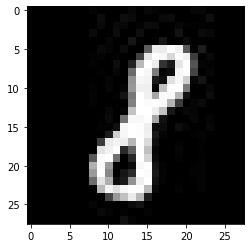

In [16]:
# 마지막 이미지 시각화
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(np.reshape(batch_xs[0], (28, 28)), cmap='gray')

In [17]:
# Step 2: MNIST 데이터 분류를 위한 오토인코더+Softmax 분류기 최적화(Fine-tuning)를 수행
# 이때 오토인코더의 파라미터들은 MNIST 데이터 재구축이 아니라 숫자 분류를 목적으로 다시 한번 최적화됨
for epoch in range(num_epochs + 100): #num_epochs = 100
    average_loss = 0
    # 모든 배치들에 대해서 최적화를 수행
    for i in range(total_batch): # total_batch = 164
        start = ((i+1) * batch_size) - batch_size
        # 데이터를 분할하기 위해 start라는 변수를 선언
        # i는 0에서 164까지 변함
        # i = 0일 때 start에 저장되는 값은 (0+1)*256)-256이므로 0이 저장
        end = ((i+1) * batch_size)
        # 데이터를 분할하기 위해 end라는 변수를 선언
        # i = 0일 때 emd에 저장되는 값은 (0+1)*256)이므로 256이 저장
        batch_xs = train_input[start:end] / 255
        # batch_xs : train 데이터의 input을 저장하는 변수
        # train_input[start:end]는 train_input[0:256]과 같음
        # 즉, train_inpuf에서 0~256에 위치하는 데이터를 불러서 batch_xs에 저장
        batch_ys = train_label[start:end]
        # batch_ys = train 데이터의 label을 저장하는 변수
        # train_label[start:end]는 train_label[0:256]과 같음
        # train_label에서 0~100에 위치하는 데이터를 불러서 batch_ys에 저장
        feed_dict = {x: batch_xs, y: batch_ys}
        # feed dictionary를 선언
        # x는 input data에 대한 placeholder이며, 
        # y는 output data 즉, label를 담는 placeholder임
        # x에 batch_xs를 담고, y에 batch_ys를 담음 
        # 옵티마이저를 실행해서 파라마터들을 업데이트
        _, finetuning_loss_print = sess.run([finetuning_train_step, finetuning_loss], feed_dict=feed_dict)
        # 평균 손실을 측정
        average_loss += finetuning_loss_print / total_batch
    # 지정된 epoch마다 학습결과를 출력
    if epoch % display_step == 0: # display_step = 5
        print("반복(Epoch): %d, Fine-tuning 손실 함수(finetuning_loss): %f" % ((epoch+display_step), average_loss))
print("Step 2 : MNIST 데이터 분류를 위한 오토인코더+Softmax 분류기 최적화 완료(Fine-Tuning)")

반복(Epoch): 5, Fine-tuning 손실 함수(finetuning_loss): 2.203775
반복(Epoch): 10, Fine-tuning 손실 함수(finetuning_loss): 1.489438
반복(Epoch): 15, Fine-tuning 손실 함수(finetuning_loss): 1.116228
반복(Epoch): 20, Fine-tuning 손실 함수(finetuning_loss): 0.912886
반복(Epoch): 25, Fine-tuning 손실 함수(finetuning_loss): 0.791080
반복(Epoch): 30, Fine-tuning 손실 함수(finetuning_loss): 0.711124
반복(Epoch): 35, Fine-tuning 손실 함수(finetuning_loss): 0.654678
반복(Epoch): 40, Fine-tuning 손실 함수(finetuning_loss): 0.612553
반복(Epoch): 45, Fine-tuning 손실 함수(finetuning_loss): 0.579751
반복(Epoch): 50, Fine-tuning 손실 함수(finetuning_loss): 0.553353
반복(Epoch): 55, Fine-tuning 손실 함수(finetuning_loss): 0.531547
반복(Epoch): 60, Fine-tuning 손실 함수(finetuning_loss): 0.513152
반복(Epoch): 65, Fine-tuning 손실 함수(finetuning_loss): 0.497363
반복(Epoch): 70, Fine-tuning 손실 함수(finetuning_loss): 0.483616
반복(Epoch): 75, Fine-tuning 손실 함수(finetuning_loss): 0.471498
반복(Epoch): 80, Fine-tuning 손실 함수(finetuning_loss): 0.460706
반복(Epoch): 85, Fine-tuning 손실 함수(finetuni

In [18]:
# 오토인코더+Softmax 분류기 모델의 정확도를 출력
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred_softmax,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("정확도(오토인코더+Softmax 분류기): %f" % sess.run(accuracy, feed_dict={x: test_input, y: test_label})) 

정확도(오토인코더+Softmax 분류기): 0.870000


# 내가 그린 데이터로 연습해보기(myMNIST)

In [19]:
# train data path
import os
path = 'D:/myMNIST/'
myimg_list = os.listdir(path)
myimg_list

['1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '7_2.png',
 '8.png',
 '9.png']

In [20]:
import cv2
mytrain_input = []
for img in myimg_list:
    img_path = os.path.join(path, img)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # cv2.imread: paht경로에 있는 이미지를 흑백으로 불러옴
    mytrain_input.append([np.array(img)])

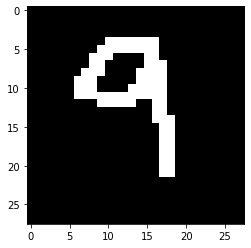

In [21]:
# 마지막 이미지 시각화
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [22]:
mytrain_input = np.reshape(mytrain_input, (-1, 784))
mytrain_input = mytrain_input.astype(np.float32)
print(mytrain_input.shape)

(10, 784)


In [23]:
mytrain_input = mytrain_input / 255
correct_prediction = tf.argmax(y_pred_softmax, 1)
sess.run(correct_prediction, feed_dict={x: mytrain_input})

array([6, 2, 5, 4, 5, 4, 2, 3, 8, 3], dtype=int64)

C:\Users\tldud\.conda\envs\tldud\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


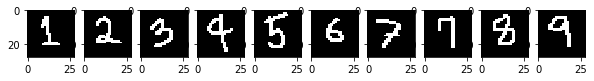

In [26]:
# 원본 MNIST 데이터와 Reconstruction 결과를 비교
f, a = plt.subplots(1, 10, figsize=(10, 1))
for i in range(len(mytrain_input)):
    a[i].imshow(np.reshape(mytrain_input[i], (28, 28)), cmap='gray')
f.show()

### 정확도 0.3
기존 ANN(3layer)보다 성능이 안좋음...